# Velocities of galaxies in groups with Galaxy Zoo 1 and Galaxy Zoo 2

In this notebook we use Galaxy Zoo 1 (GZ1) and Galaxy Zoo 2 (GZ2) data which has been matched to group data from Yang, specifically calculating velcoity dispersions for galaxies within groups.

The GZ1 and GZ2 data can be found at https://data.galaxyzoo.org/
<br>
Information on Data Release 7 (DR7) of the Sloan Digital Sky Survery (SDSS) can be found at https://classic.sdss.org/dr7/
<br>
The Yang group data can be found at https://gax.sjtu.edu.cn/data/Group.html

#### Data
There are 4 different data sets we are using from the GZ data page. For GZ1 we are using "Table 2", which are galaxies from the entire GZ1 data set with spectra available in SDSS DR7 and "Table 3", which are galaxies from the entire GZ1 data set with no spectra available in SDSS DR7. These have 667,944 and 225,268 galaxies in them respectively.
<br>
For GZ1 we are using "Table 5", which are galaxies from the main GZ2 sample spectroscopic redshifts available in SDSS DR7 and "Table 6", which are galaxies from the main GZ2 sample with only photometric redshifts available in SDSS DR7. These have 243,500 and 42,462 galaxies in them respectively.
<br>
We use Yang Catalogue "PetroC" containing 639,359 galaxies and 473,872 groups.

#### Matching GZ1, GZ2 and Yang
The Yang data set covers redshifts $0.01 \leq z \leq 0.2$, whereas GZ1 and GZ2 cover a greater redshift range. Hence we expect to lose some galaxies when we match the GZ1&2 data to the Yang catalogue. We match the GZ1&2 data to the Yang data by right-ascension (ra) and declination (dec) with a maximum error in position of 5 arcsec, preferentially choosing galaxies with spectra available if both a galaxy from the spectroscopic data and from the photometric data match to the same Yang galaxy.

The total number of matches in Yang for each of the 4 galaxy zoo data sets are:

- GZ1 spectroscopic: 586,594 galaxies
- GZ1 photometric: 42,197 galaxies
- GZ2 spectroscopic: 233,767 galaxies
- GZ2 photometric: 19,451 galaxies

In total there are 628,791 galaxies in Yang with GZ1 data and 253,218 galaxies in Yang with GZ2 data, with 629,365 galaxies from Yang having either GZ1 or GZ2 data and 252,644 galaxies with both GZ1 and GZ2 data.

From now on we shall refer to the Yang group data set of 639,359 galaxies as Yang, and the matched GZ1&2 and Yang data sets as GZ1 and GZ2.

### Importing the data
First we import the necessary packages and import the data into an Astropy Table "all_data".

We display the head of the table to get an idea of what the data looks like.

In [1]:
# from astropy.table import Table
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Import .fits data as a table
data_filename = "E:\\MPhys Project\\Main Data\\Group_GZ1_GZ2_full.fits" # All galaxies in group data set with matched GZ1 & Gz2 galaxies

with fits.open(data_filename) as data:
    all_data = Table(data[1].data)

# Display head of data
display(all_data[0:5])

# Use identifiers in data to create 4 tables containing only GZ1/GZ2 spectroscopic\photometric data
gz1_gz2_data = all_data[(all_data["GZ1"] == 1) | (all_data["GZ2"] == 1)]
gz1_spectro = all_data[all_data["GZ1_SpectroZ"] == 1]
gz1_photo = all_data[all_data["GZ1_PhotoZ"] == 1]
gz2_spectro = all_data[all_data["GZ2_SpectroZ"] == 1]
gz2_photo = all_data[all_data["GZ2_PhotoZ"] == 1]

galaxy ID,NYU-VAGC ID object ID,ra_galaxy,dec_galaxy,z_galaxy,apparent magnitude r_band,magnitude limit r_band,completeness,col9 Petro,col10 Petro,col11 Model,col12 Model,redshift source type,group id,brightest galaxy,most massive galaxy,RA_group,dec_group,z_group,group L_-19.5 log L_odoth2,group stellar mass,halo mass1,halo mass2,mean separation brighter,mean separation massive,f_edge,ID1,ID2,group_size,OBJID_GZ1,RA_GZ1,DEC_GZ1,NVOTE_GZ1,P_EL,P_CW,P_ACW,P_EDGE,P_DK,P_MG,P_CS,P_EL_DEBIASED,P_CS_DEBIASED,SPIRAL,ELLIPTICAL,UNCERTAIN,U_GZ1,G_GZ1,R_GZ1,I_GZ1,Z_GZ1,UERR_GZ1,GERR_GZ1,RERR_GZ1,IERR_GZ1,ZERR_GZ1,R50_ARCSEC_GZ1,R90_ARCSEC_GZ1,REDSHIFT_GZ1,REDSHIFTERR_GZ1,REDSHIFTCONF_GZ1,MU_GZ1,MG_GZ1,MR_GZ1,MI_GZ1,MZ_GZ1,MUERR_GZ1,MGERR_GZ1,MRERR_GZ1,MIERR_GZ1,MZERR_GZ1,R50_KPC_GZ1,specobjid_GZ2,dr8objid_GZ2,dr7objid_GZ2,ra_GZ2,dec_GZ2,rastring_GZ2,decstring_GZ2,sample_GZ2,gz2class,total_classifications_GZ2,total_votes_GZ2,t01_smooth_or_features_a01_smooth_count,t01_smooth_or_features_a01_smooth_weight,t01_smooth_or_features_a01_smooth_fraction,t01_smooth_or_features_a01_smooth_weighted_fraction,t01_smooth_or_features_a01_smooth_debiased,t01_smooth_or_features_a01_smooth_flag,t01_smooth_or_features_a02_features_or_disk_count,t01_smooth_or_features_a02_features_or_disk_weight,t01_smooth_or_features_a02_features_or_disk_fraction,t01_smooth_or_features_a02_features_or_disk_weighted_fraction,t01_smooth_or_features_a02_features_or_disk_debiased,t01_smooth_or_features_a02_features_or_disk_flag,t01_smooth_or_features_a03_star_or_artifact_count,t01_smooth_or_features_a03_star_or_artifact_weight,t01_smooth_or_features_a03_star_or_artifact_fraction,t01_smooth_or_features_a03_star_or_artifact_weighted_fraction,t01_smooth_or_features_a03_star_or_artifact_debiased,t01_smooth_or_features_a03_star_or_artifact_flag,t02_edgeon_a04_yes_count,t02_edgeon_a04_yes_weight,t02_edgeon_a04_yes_fraction,t02_edgeon_a04_yes_weighted_fraction,t02_edgeon_a04_yes_debiased,t02_edgeon_a04_yes_flag,t02_edgeon_a05_no_count,t02_edgeon_a05_no_weight,t02_edgeon_a05_no_fraction,t02_edgeon_a05_no_weighted_fraction,t02_edgeon_a05_no_debiased,t02_edgeon_a05_no_flag,t03_bar_a06_bar_count,t03_bar_a06_bar_weight,t03_bar_a06_bar_fraction,t03_bar_a06_bar_weighted_fraction,t03_bar_a06_bar_debiased,t03_bar_a06_bar_flag,t03_bar_a07_no_bar_count,t03_bar_a07_no_bar_weight,t03_bar_a07_no_bar_fraction,t03_bar_a07_no_bar_weighted_fraction,t03_bar_a07_no_bar_debiased,t03_bar_a07_no_bar_flag,t04_spiral_a08_spiral_count,t04_spiral_a08_spiral_weight,t04_spiral_a08_spiral_fraction,t04_spiral_a08_spiral_weighted_fraction,t04_spiral_a08_spiral_debiased,t04_spiral_a08_spiral_flag,t04_spiral_a09_no_spiral_count,t04_spiral_a09_no_spiral_weight,t04_spiral_a09_no_spiral_fraction,t04_spiral_a09_no_spiral_weighted_fraction,t04_spiral_a09_no_spiral_debiased,t04_spiral_a09_no_spiral_flag,t05_bulge_prominence_a10_no_bulge_count,t05_bulge_prominence_a10_no_bulge_weight,t05_bulge_prominence_a10_no_bulge_fraction,t05_bulge_prominence_a10_no_bulge_weighted_fraction,t05_bulge_prominence_a10_no_bulge_debiased,t05_bulge_prominence_a10_no_bulge_flag,t05_bulge_prominence_a11_just_noticeable_count,t05_bulge_prominence_a11_just_noticeable_weight,t05_bulge_prominence_a11_just_noticeable_fraction,t05_bulge_prominence_a11_just_noticeable_weighted_fraction,t05_bulge_prominence_a11_just_noticeable_debiased,t05_bulge_prominence_a11_just_noticeable_flag,t05_bulge_prominence_a12_obvious_count,t05_bulge_prominence_a12_obvious_weight,t05_bulge_prominence_a12_obvious_fraction,t05_bulge_prominence_a12_obvious_weighted_fraction,t05_bulge_prominence_a12_obvious_debiased,t05_bulge_prominence_a12_obvious_flag,t05_bulge_prominence_a13_dominant_count,t05_bulge_prominence_a13_dominant_weight,t05_bulge_prominence_a13_dominant_fraction,t05_bulge_prominence_a13_dominant_weighted_fraction,t05_bulge_prominence_a13_dominant_debiased,t05_bulge_prominence_a13_dominant_flag,t06_odd_a14_yes_count,t06_odd_a14_yes_weight,t06_odd_a14_yes_fraction,t

### Classifying mergers
Many of the galaxies in our data set have classification data from both GZ1 and GZ2. As GZ1 and GZ2 have different decision trees, we must classify mergers in a different way for each. We can then compare the classifications for galaxies which are in both sets, to see if our classification methods are consistent.

For GZ1 we will use the threshold for merger classification as described in [Darg et al. (2009)](https://arxiv.org/pdf/0903.4937.pdf):
- merger weighted vote fraction $p_m$ > 0.4

Note that this was used in Darg et al. (2009) for only galaxies with redshifts $0.005 < z < 0.1$, but we will use it for galaxies in the range $0.1 \leq z \leq 0.2$ here also.

For GZ2 we will use the threshold for merger classification we have done previously:
- "t06_odd_a14_yes_count" $\geq$ 20
- "t06_odd_a14_yes_debiased" > 0.42
- "t08_odd_feature_a24_merger_count" $\geq$ 10
- "t08_odd_feature_a24_merger_debiased" > 0.4

In [22]:
# Create a new column in the data for GZ1 mergers, with a value of 1 if the galaxy is classified as a merger, and 0 if not
all_data_pandas = all_data.to_pandas()
all_data_pandas["GZ1_merger_yes"] = 0
all_data_pandas.loc[all_data_pandas["P_MG"] > 0.4, "GZ1_merger_yes"] = 1

# Do the same for GZ2 mergers
all_data_pandas["GZ2_merger_yes"] = 0
all_data_pandas.loc[(all_data_pandas["GZ2"] == 1) & (all_data_pandas["t06_odd_a14_yes_count"] >= 20) & (all_data_pandas["t06_odd_a14_yes_debiased"] > 0.42) & (all_data_pandas["t08_odd_feature_a24_merger_count"] >= 10) & (all_data_pandas["t08_odd_feature_a24_merger_debiased"] > 0.4), "GZ2_merger_yes"] = 1

# Return data frame
all_data = Table.from_pandas(all_data_pandas)
all_data["Merger_classifications"] = all_data["GZ1_merger_yes"] + all_data["GZ2_merger_yes"]

As we are looking at velocities in the group, we are only interested in groups with size $N \geq 2$. We therefore create a copy of our data containing only these groups.

In [2]:
# Create copy of data with only groups N >= 2
groups_larger_than_1 = all_data[all_data["group_size"] >= 2]

# Print number of galaxies and number of groups remaining
print("Number of galaxies in groups with size 2 or greater: " + str(len(groups_larger_than_1)))
print("Number of groups with size 2 or greater: " + str(len(np.unique(groups_larger_than_1["group id"]))))

Number of galaxies in groups with size 2 or greater: 233412
Number of groups with size 2 or greater: 67925


### Calculating velocities
We calculate the proper velocities $v_i$ of a galaxy $i$ within a group as is done in [Danese et al. (1980)](http://articles.adsabs.harvard.edu/pdf/1980A%26A....82..322D):
$$v_i = c \cdot \frac{z_i - z_\text{group}}{1+z_\text{group}}$$
where $z_i$ is the redshift of a galaxy $i$ and $z_\text{group}$ is the mean redshift of all the members of a group. The velocity dispersion of a group can then be calculated using
$$\sigma = \sqrt{\frac{1}{N_\text{group}-1}\sum_{i=1}^{N_\text{group}}(v_i - \left< v_i \right>)^2}$$
We do this for our sample of galaxies below. Note that by using our definition of $v_i$, $\left< v_i \right> = 0$ since $\sum_{i=1}^{N_\text{group}}(z_i - z_\text{group}) = 0$ by definition.

First we use the pandas groupby function to group the data together into groups, creating a dictionary with the group id as the key, and the indicies of the galaxies in the group as the values. We then iterate over every group, calculating the mean redshift $z_\text{group}$, then the galaxy velocities $v_i$, and finally the velocity dispersion for the group $\sigma$.

In [4]:
# Select only needed columns
groups_data_needed = groups_larger_than_1[["galaxy ID", "group id", "group_size", "z_galaxy"]].to_pandas()
# Groupby galaxy group id, creating a dictrionary with group id as the key, and the indicies of the galaxies as values
groups = groups_data_needed.groupby("group id").indices

# Add the new desired columns to the DataFrame
groups_data_needed["z_group_mean"] = 0
groups_data_needed["v_i"] = 0
groups_data_needed["velocity_dispersion"] = 0

# Print the number of groups the calculation must be done for
print("Number of groups to calculate for: " + str(len(groups)))
i = 1

for key, values in groups.items(): # Iterate over the dictionary of group ids
    # Get group size
    group_size = groups_data_needed.loc[values[0], "group_size"]
    
    # Calculate mean redshift of group
    groups_data_needed.loc[values, "z_group_mean"] = groups_data_needed.loc[values, "z_galaxy"].mean()
    z_mean = groups_data_needed.loc[values[0], "z_group_mean"]
    
    # Calculate the individual galaxy velocities for all galaxies in the group
    groups_data_needed.loc[values, "v_i"] = (groups_data_needed.loc[values, "z_galaxy"] - z_mean) / (1 + z_mean) * 299792458
    
    # Calculate the velocity dispersion of the group
    groups_data_needed.loc[values, "velocity_dispersion"] = (1/(group_size-1) * ((groups_data_needed.loc[values, "v_i"])**2).sum())**(1/2)
    
    # Progress checker
    if i % 5000 == 0:
        print("Progress: " + str(i) + " groups done")
    elif i == len(groups):
        print("Progress: done")
    i += 1

Number of groups to calculate for: 67925
Progress: 5000 groups done
Progress: 10000 groups done
Progress: 15000 groups done
Progress: 20000 groups done
Progress: 25000 groups done
Progress: 30000 groups done
Progress: 35000 groups done
Progress: 40000 groups done
Progress: 45000 groups done
Progress: 50000 groups done
Progress: 55000 groups done
Progress: 60000 groups done
Progress: 65000 groups done
Progress: done


With the velocity data calculated, we show the head of the data to see the new columns.

In [5]:
# Display head of data
display(groups_data_needed[0:5])
groups_data_needed_copy = groups_data_needed.copy() # Create copy of data

,galaxy ID,group id,group_size,z_galaxy,z_group_mean,v_i,velocity_dispersion
0,2,23485,2,0.053818,0.053934,-33095.861926,46804.616794
1,3,23485,2,0.054050,0.053934,33095.861926,46804.616794
2,7,23486,2,0.139661,0.139570,24031.915064,33986.260213
3,8,23486,2,0.139478,0.139570,-24031.915064,33986.260213
4,11,8376,4,0.139633,0.139137,130436.111834,88685.375220


We now merge this calculated data with our full data set.

In [6]:
all_data_pandas = all_data.to_pandas() # Pandas DataFram of full data

# Merge the two DataFrames, keeping all the rows in the full DataFrame
merged = pd.merge(all_data_pandas, groups_data_needed[["galaxy ID", "z_group_mean", "v_i", "velocity_dispersion"]],
                  on="galaxy ID", how="left")
# Display head of data
display(merged.head())

# Turn DataFrame back into astropy table
all_data = Table.from_pandas(merged)

,galaxy ID,NYU-VAGC ID object ID,ra_galaxy,dec_galaxy,z_galaxy,apparent magnitude r_band,magnitude limit r_band,completeness,col9 Petro,col10 Petro,...,Yang_GZ2_Separation,GZ1_SpectroZ,GZ1_PhotoZ,GZ1,GZ2_SpectroZ,GZ2_PhotoZ,GZ2,z_group_mean,v_i,velocity_dispersion
0,1,750,38.049133,0.224026,0.054022,15.939070,17.620001,0.994186,-20.207098,0.906209,...,0.289745,1,0,1,1,0,1,NaN,NaN,NaN
1,2,751,38.352526,0.212491,0.053818,16.786047,17.620001,0.987805,-19.363531,0.820707,...,0.093179,1,0,1,1,0,1,0.053934,-33095.861926,46804.616794
2,3,752,38.363598,0.210654,0.054050,15.090300,17.620001,0.987805,-20.966141,0.758547,...,0.072936,1,0,1,1,0,1,0.053934,33095.861926,46804.616794
3,4,994,54.450341,0.572606,0.138504,17.604034,17.620001,0.918367,-20.681068,0.880466,...,NaN,0,0,0,0,0,0,NaN,NaN,NaN
4,5,1010,54.534881,0.578615,0.128955,17.415402,17.620001,0.918367,-20.712832,0.918161,...,NaN,1,0,1,0,0,0,NaN,NaN,NaN


In [8]:
# velocity_data_yang_redshifts = Table.from_pandas(groups_data_needed)
# velocity_data_yang_redshifts.write("velocity_data_yang_redshifts.fits", format="fits")

### Distribution of velocities and velocity dispersions
To get an idea of how the velocities and velocity dispersions are spread, we will plot histograms for them. Note that this is only for groups with $N \geq 2$, as lone galaxies do not have a velocity w.r.t the group centre.

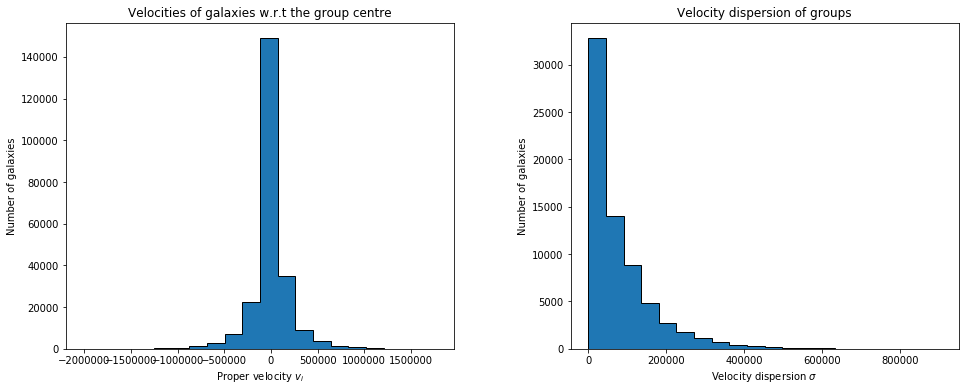

In [25]:
groups_with_velocity = all_data[all_data["group_size"] >= 2].to_pandas()
velocities = groups_with_velocity["v_i"].copy()
velocity_dispersions = groups_with_velocity.drop_duplicates(subset=["group id"], keep="first")["velocity_dispersion"]  # Only keep 1 row for each group

fig, ax = plt.subplots(1, 2, figsize=(16,6))

# Plot histogram of individual velocities
ax[0].hist(velocities, bins=20, edgecolor="black", histtype="stepfilled")
#ax[0].set_xscale("log")
#ax[0].set_yscale("log")
ax[0].set_xlabel("Proper velocity $v_i$")
ax[0].set_ylabel("Number of galaxies")
ax[0].set_title("Velocities of galaxies w.r.t the group centre")

# Plot histogram of velocity dispersions
ax[1].hist(velocity_dispersions, bins=20, edgecolor="black", histtype="stepfilled")
#ax[1].set_xscale("log")
#ax[1].set_yscale("log")
ax[1].set_xlabel("Velocity dispersion $\sigma$")
ax[1].set_ylabel("Number of galaxies")
ax[1].set_title("Velocity dispersion of groups")

fig.subplots_adjust(wspace=0.3)

plt.show()

As we might have expected, the individual velocities are roughly evenly spread around $v_i=0$, and smaller velocities are much more common than very large ones. Smaller velocity dispersions are also much more common than very large ones.

To be able to see the data more clearly, we will plot the graphs on logarithmic axes using logarthmically spaced velocity bins. Due to the possibility of the individual velocities being negative, we will take the absolute value of them for this plot. Some groups also have zero velocities or zero velocity dispersions, which will be set to 1 here to avoid $\log(0)$ errors.

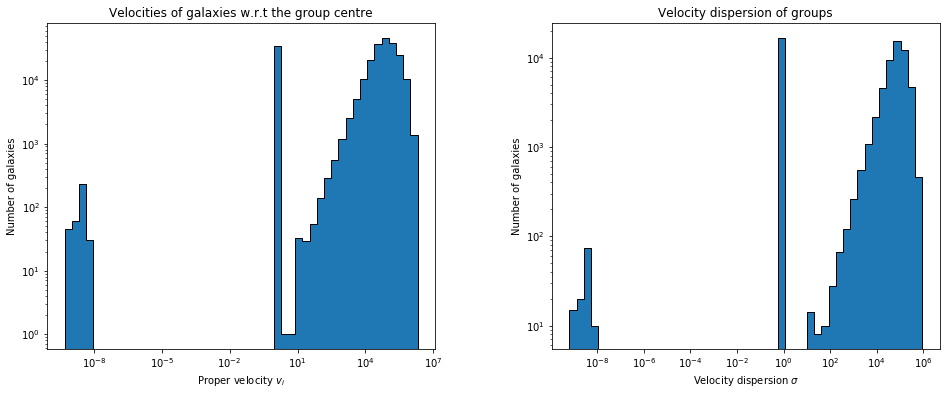

In [26]:
velocities = abs(np.array(velocities))
velocity_dispersions = np.array(velocity_dispersions)

for x in range(len(velocities)):
    if velocities[x] == 0:
        velocities[x] = 1
        
for x in range(len(velocity_dispersions)):
    if velocity_dispersions[x] == 0:
        velocity_dispersions[x] = 1

# Create logarithmically spaced bins for individual velocities
velocity_bin_start = np.log10(min(velocities))
velocity_bin_end = np.log10(max(velocities))
velocity_num_of_bins = 50
velocity_log_bins = np.logspace(velocity_bin_start, velocity_bin_end, velocity_num_of_bins)

# Create logarithmically spaced bins for individual velocities
velocity_dispersion_bin_start = np.log10(min(velocity_dispersions))
velocity_dispersion_bin_end = np.log10(max(velocity_dispersions))
velocity_dispersion_num_of_bins = 50
velocity_dispersion_log_bins = np.logspace(velocity_dispersion_bin_start, velocity_dispersion_bin_end, velocity_dispersion_num_of_bins)

fig, ax = plt.subplots(1, 2, figsize=(16,6))

# Plot histogram of individual velocities
ax[0].hist(velocities, bins=velocity_log_bins, edgecolor="black", histtype="stepfilled")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlabel("Proper velocity $v_i$")
ax[0].set_ylabel("Number of galaxies")
ax[0].set_title("Velocities of galaxies w.r.t the group centre")

# Plot histogram of velocity dispersions
ax[1].hist(velocity_dispersions, bins=velocity_dispersion_log_bins, edgecolor="black", histtype="stepfilled")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xlabel("Velocity dispersion $\sigma$")
ax[1].set_ylabel("Number of galaxies")
ax[1].set_title("Velocity dispersion of groups")

fig.subplots_adjust(wspace=0.3)

plt.show()

From the graphs we can see a large peak at velocities or velocity dispersions of 1. These are the galaxies and groups that had values of zero which we then set to 1, of which there are many. There are also some galaxies and groups with velocity dispersions of the order $10^{-9} \text{-} 10^{-8}$. These are likely also galaxies and groups with what should be a zero velocity, but is slightly greater than due to some precision errors in calculations.

When we calculate the merger fraction, these galaxies will be included in the first bin along with the galaxies and groups which do have zero velocities.

We plot the $v_i$ and $\sigma$ below for only galaxies with $v_i \geq 10$ and groups with $\sigma \geq 10$ to better see how galaxies and groups with non-zero velocities are spread.

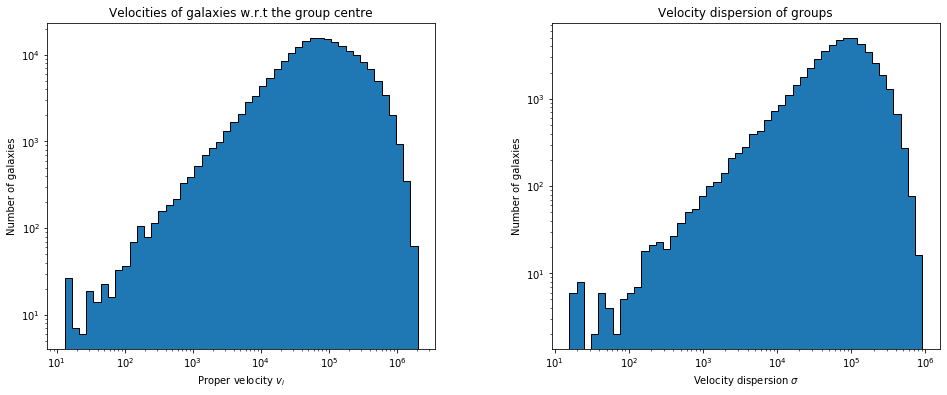

In [27]:
velocities = abs(np.array(velocities))
velocity_dispersions = np.array(velocity_dispersions)

velocities = velocities[velocities >= 10]
velocity_dispersions = velocity_dispersions[velocity_dispersions >= 10]

# Create logarithmically spaced bins for individual velocities
velocity_bin_start = np.log10(min(velocities))
velocity_bin_end = np.log10(max(velocities))
velocity_num_of_bins = 50
velocity_log_bins = np.logspace(velocity_bin_start, velocity_bin_end, velocity_num_of_bins)

# Create logarithmically spaced bins for individual velocities
velocity_dispersion_bin_start = np.log10(min(velocity_dispersions))
velocity_dispersion_bin_end = np.log10(max(velocity_dispersions))
velocity_dispersion_num_of_bins = 50
velocity_dispersion_log_bins = np.logspace(velocity_dispersion_bin_start, velocity_dispersion_bin_end, velocity_dispersion_num_of_bins)

fig, ax = plt.subplots(1, 2, figsize=(16,6))

# Plot histogram of individual velocities
ax[0].hist(velocities, bins=velocity_log_bins, edgecolor="black", histtype="stepfilled")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlabel("Proper velocity $v_i$")
ax[0].set_ylabel("Number of galaxies")
ax[0].set_title("Velocities of galaxies w.r.t the group centre")

# Plot histogram of velocity dispersions
ax[1].hist(velocity_dispersions, bins=velocity_dispersion_log_bins, edgecolor="black", histtype="stepfilled")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xlabel("Velocity dispersion $\sigma$")
ax[1].set_ylabel("Number of galaxies")
ax[1].set_title("Velocity dispersion of groups")

fig.subplots_adjust(wspace=0.3)

plt.show()

## The merger fraction
Now that we have calculated velocities and velocity dispersions for the galaxies and groups in our data set, we want to see how the merger fraction $f_m$ changes with these parameters.

We first bin the data such that there are an equal number of galaxies or groups in each bin, for the velocities and the velocity dispersion. We plot a histogram of the binned data to check that there are indeed an equal number in each bin.

Velocity bins: [      0.            6904.5926856    21206.25502571   36723.16275331
   55108.44449338   79284.89125986  115648.65218429  179465.82816466
  315956.51672248 2008639.5313525 ]
Velocity dispersion bins: [     0.          15793.51270893  43576.48548984  70854.32948175
 101772.58235665 140740.25528948 196133.27294567 272468.98140732
 380974.03276523 906462.68743984]


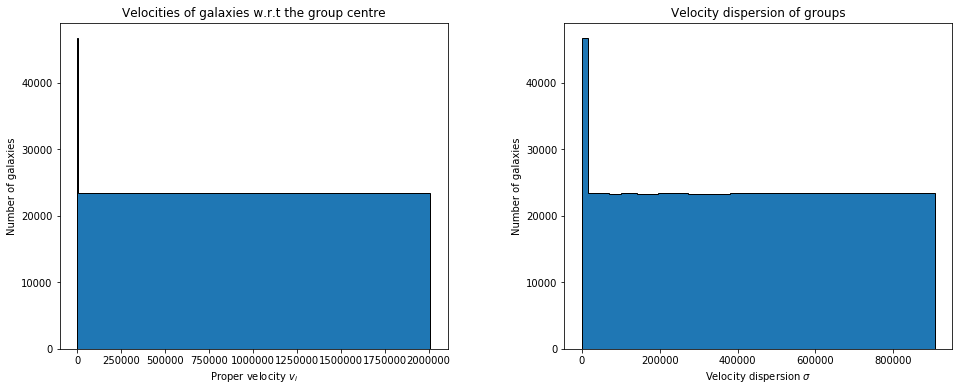

In [66]:
# Create bins of equal size for velocities
velocity_data = all_data[all_data["group_size"] >= 2]
velocity_data["v_i"] = abs(velocity_data["v_i"])

velocity_equal_bins = pd.qcut(x=velocity_data["v_i"], q=10, labels=False, retbins=True, duplicates="drop")[1]

velocity_dispersion_equal_bins = pd.qcut(x=velocity_data["velocity_dispersion"], q=10, labels=False, retbins=True, duplicates="drop")[1]

# velocity_equal_log_bins = pd.qcut(x=np.log10(velocity_data["v_i"]), q=10, labels=False, retbins=True, duplicates="drop")[1]
# velocity_equal_log_bins = np.power(10, equal_log_bins)

# velocity_dispersion_log_bins = pd.qcut(x=np.log10(velocity_data["velocity_dispersion"]), q=10, labels=False, retbins=True, duplicates="drop")[1]
# velocity_dispersion_equal_log_bins = np.power(10, equal_log_bins)

# Print the bins that have been calculated
print("Velocity bins: " + str(velocity_equal_bins))
print("Velocity dispersion bins: " + str(velocity_dispersion_equal_bins))

fig, ax = plt.subplots(1, 2, figsize=(16,6))

# Plot histogram of velocity using velocity bins
ax[0].hist(velocity_data["v_i"], bins=velocity_equal_bins, edgecolor="black", histtype="stepfilled")
#ax[0].set_xscale("log")
#ax[0].set_yscale("log")
ax[0].set_xlabel("Proper velocity $v_i$")
ax[0].set_ylabel("Number of galaxies")
ax[0].set_title("Velocities of galaxies w.r.t the group centre")

# Plot histogram of velocity dispersion using velocity dispersion bins
ax[1].hist(velocity_data["velocity_dispersion"], bins=velocity_dispersion_equal_bins, edgecolor="black", histtype="stepfilled")
#ax[1].set_xscale("log")
#ax[1].set_yscale("log")
ax[1].set_xlabel("Velocity dispersion $\sigma$")
ax[1].set_ylabel("Number of galaxies")
ax[1].set_title("Velocity dispersion of groups")

fig.subplots_adjust(wspace=0.3)

plt.show()

Due to the high number of galaxies and grousp with very low merger fractions, it is difficult to get the smallest bin to have the same number of galaxies/groups as the other bins, however the other bins do indeed have a similar number of galaxies/groups in each bin.

### Galaxy velocities
We first calculate the merger fraction of the individual galaxy velocities. To attempt to estimate the error on our merger fraction, we will boostrap the data. For each iteration, we will choose a random sample of our 233,412 galaxies with velocity data and recalculate the merger fraction using the same bins. This has been done 1000 times, and the minimum and maximum merger fraction at each point will be taken and used to fill between on our plot.

In [67]:
def merger_fraction_velocity_bootstrapping(data, velocity_bins, iterations, bootstrapping_fraction):
    """For each iteration (the number given by "iterations") takes a random sample of the data
    (the fraction given by "bootstrapping_fraction") and calculates the merger fraction
    using the bins provided. Returns an array of size (iterations x number of points)
    containing every merger fraction calculated."""
    
    # Resample table with only the data needed to speed up processing
    data = data[["v_i", "Merger_classifications"]].to_pandas()
    
    # Calculate number of points for plotting
    number_of_points = len(velocity_bins) - 1
    
    # Calculate the size of each sample to calculate merger fraction with
    number_for_boostrapping = int(bootstrapping_fraction * len(data))
    
    # Create numpy array to store merger fraction calculations in
    merger_fractions = np.zeros((iterations, number_of_points))
    
    # Loop to calculate merger fraction
    for x in range(iterations):
        # Generate new sample of the data
        data_sampled = data.sample(number_for_boostrapping)
        
        # Bin data by velocities, with the bin sizes specified
        allbinned, bin_edges = np.histogram(data_sampled["v_i"], bins=velocity_bins)
        mergersbinned, bin_edges = np.histogram(data_sampled[data_sampled["Merger_classifications"] > 0]["v_i"], bins=velocity_bins)
    
        allbinned = allbinned.astype(float)
        mergersbinned = mergersbinned.astype(float)
    
        # Find merger fraction and add to numpy array of all merger fractions
        merger_fractions[x] = mergersbinned / allbinned
        
    return merger_fractions

# Call function with all_data and calculated velocity bins
merger_fraction_velocity_bootstrapped = merger_fraction_velocity_bootstrapping(velocity_data, velocity_equal_bins, iterations=1000, bootstrapping_fraction=0.9)
merger_fraction_velocity_bootstrapped_min = np.amin(merger_fraction_velocity_bootstrapped, axis=0) # Find minimum of each point
merger_fraction_velocity_bootstrapped_max = np.amax(merger_fraction_velocity_bootstrapped, axis=0) # Find maximum of each point

# Print minimum and maximum merger fractions of each point
print("Bootstrapping velocity minimum: " + str(merger_fraction_velocity_bootstrapped_min))
print("Bootstrapping velocity maximum: " + str(merger_fraction_velocity_bootstrapped_max))

Bootstrapping velocity minimum: [0.08708466 0.04463519 0.04152761 0.04250655 0.04066974 0.04222402
 0.04337867 0.03774758 0.03197065]
Bootstrapping velocity maximum: [0.09001719 0.04728638 0.04429806 0.04511708 0.04383418 0.04481605
 0.04621072 0.04026559 0.03501261]


,Average galaxy velocity in bin,Merger fraction $f_m$,Galaxies in bin
0,880.479734,0.088557,46682
1,14001.431194,0.045928,23341
2,28845.031909,0.042927,23342
3,45642.098211,0.043743,23341
4,66505.452378,0.042457,23341
5,95882.110280,0.043614,23341
6,144270.336858,0.044728,23341
7,237517.230691,0.039116,23341
8,539763.944094,0.033545,23342


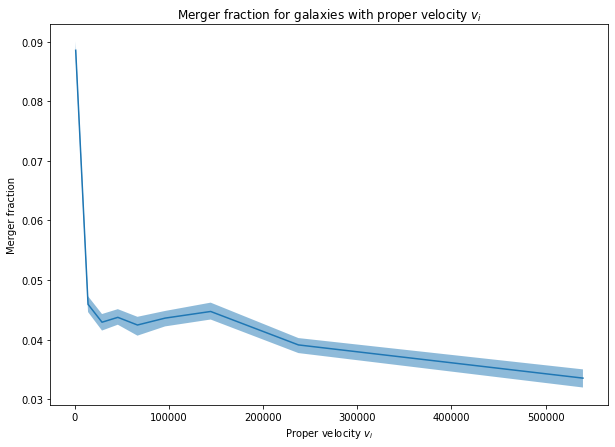

In [68]:
# Define a function that given some data, will return the merger fraction against galaxy velocities
def merger_fraction_velocity_binning(data, velocity_bins):
    """Takes data, picks out mergers and calculates the merger fraction using
    the bins provided. Returns an array of merger fraction against galaxy velocities,
    the average velocity of galaxies in bin for plotting and the number
    of galaxies in each bin."""
    
    # Resample table with only the data needed
    data = data[["v_i", "Merger_classifications"]]
    
    # Bin data by velocity, with the bin sizes specified
    allbinned, bin_edges = np.histogram(data["v_i"], bins=velocity_bins)
    mergersbinned, bin_edges = np.histogram(data[data["Merger_classifications"] > 0]["v_i"], bins=velocity_bins)
    
    # Calculate the average velocity in each bin for plotting data
    bin_centres=[]
    for i in range(len(bin_edges) - 1):
        bin_centres.append(data[(data["v_i"] >= bin_edges[i]) & (data["v_i"] < bin_edges[i + 1])]["v_i"].mean())
    
    allbinned = allbinned.astype(float)
    mergersbinned = mergersbinned.astype(float)
    
    # Find merger fraction
    merger_fraction_group = mergersbinned / allbinned
    
    return merger_fraction_group, bin_centres, allbinned.astype(int)

# Call function with all_data and calculated velocity bins
merger_fraction_velocities, velocity_bin_centres, galaxies_in_bin = merger_fraction_velocity_binning(velocity_data, velocity_equal_bins)

# Create dataframe of average galaxy velocity, merger fraction and gaalxies in each bin and display it
merger_fraction_velocity_info = list(zip(velocity_bin_centres, merger_fraction_velocities, galaxies_in_bin))
display(pd.DataFrame(merger_fraction_velocity_info, columns=["Average galaxy velocity in bin", "Merger fraction $f_m$", "Galaxies in bin"]))

# Plot a line plot of merger fraction with the minimum and maximum from bootstrapping filled in
plt.figure(figsize=(10,7))
plt.plot(velocity_bin_centres, merger_fraction_velocities)
plt.fill_between(velocity_bin_centres, merger_fraction_velocity_bootstrapped_min, merger_fraction_velocity_bootstrapped_max, alpha=0.5)
#plt.xscale("log")
plt.xlabel("Proper velocity $v_i$")
plt.ylabel("Merger fraction")
plt.title("Merger fraction for galaxies with proper velocity $v_i$")
plt.show()

There is a very large peak in the merger fraction in the first bin of $\sim 9 \%$, before dropping down to roughly half of that. The merger fraction then remains fairly constant before dropping again at very high velocities to $\sim 3.3 \%$.

### Group velocity dispersion
We now calculate the merger fraction against group velocity dispersion velocities. We again perform a bootstrapping procedure in order to estimate the error on the merger fraction.

In [69]:
def merger_fraction_velocity_bootstrapping(data, velocity_bins, iterations, bootstrapping_fraction):
    """For each iteration (the number given by "iterations") takes a random sample of the data
    (the fraction given by "bootstrapping_fraction") and calculates the merger fraction
    using the bins provided. Returns an array of size (iterations x number of points)
    containing every merger fraction calculated."""
    
    # Resample table with only the data needed to speed up processing
    data = data[["velocity_dispersion", "Merger_classifications"]].to_pandas()
    
    # Calculate number of points for plotting
    number_of_points = len(velocity_bins) - 1
    
    #Calculate the size of each sample to calculate merger fraction with
    number_for_boostrapping = int(bootstrapping_fraction * len(data))
    
    # Create numpy array to store merger fraction calculations in
    merger_fractions = np.zeros((iterations, number_of_points))
    
    # Loop to calculate merger fraction
    for x in range(iterations):
        # Generate new sample of the data
        data_sampled = data.sample(number_for_boostrapping)
        
        # Bin data by velocity dispersion, with the bin sizes specified
        allbinned, bin_edges = np.histogram(data_sampled["velocity_dispersion"], bins=velocity_bins)
        mergersbinned, bin_edges = np.histogram(data_sampled[data_sampled["Merger_classifications"] > 0]["velocity_dispersion"], bins=velocity_bins)
    
        allbinned = allbinned.astype(float)
        mergersbinned = mergersbinned.astype(float)
    
        # Find merger fraction and add to numpy array of all merger fractions
        merger_fractions[x] = mergersbinned / allbinned
        
    return merger_fractions

# Call function with all_data and calculated velocity dispersion bins
merger_fraction_velocity_dispersion_bootstrapped = merger_fraction_velocity_bootstrapping(velocity_data, velocity_dispersion_equal_bins, iterations=1000, bootstrapping_fraction=0.9)
merger_fraction_velocity_dispersion_bootstrapped_min = np.amin(merger_fraction_velocity_dispersion_bootstrapped, axis=0) # Find minimum of each point
merger_fraction_velocity_dispersion_bootstrapped_max = np.amax(merger_fraction_velocity_dispersion_bootstrapped, axis=0) # Find maximum of each point

# Print minimum and maximum merger fractions of each point
print("Bootstrapping velocity dispersion minimum: " + str(merger_fraction_velocity_dispersion_bootstrapped_min))
print("Bootstrapping velocity dispersion maximum: " + str(merger_fraction_velocity_dispersion_bootstrapped_max))

Bootstrapping velocity dispersion minimum: [0.0867239  0.0395757  0.03987423 0.04167855 0.04565207 0.04688836
 0.04129709 0.03813337 0.03260611]
Bootstrapping velocity dispersion maximum: [0.08928189 0.04214177 0.04263013 0.04442753 0.04859724 0.05008355
 0.04431856 0.04118687 0.03548892]


,Average group velocity dispersion in bin,Merger fraction $f_m$,Galaxies in bin,Groups in bin
0,2023.981008,0.088002,46681,22267
1,29823.170028,0.040954,23343,9920
2,57102.064883,0.041258,23341,9126
3,85793.467456,0.043022,23337,8125
4,120154.809049,0.047080,23343,6867
5,166868.522477,0.048556,23334,5259
6,232686.516228,0.042625,23343,3396
7,323434.912092,0.039708,23295,2044
8,503759.220802,0.033982,23395,921


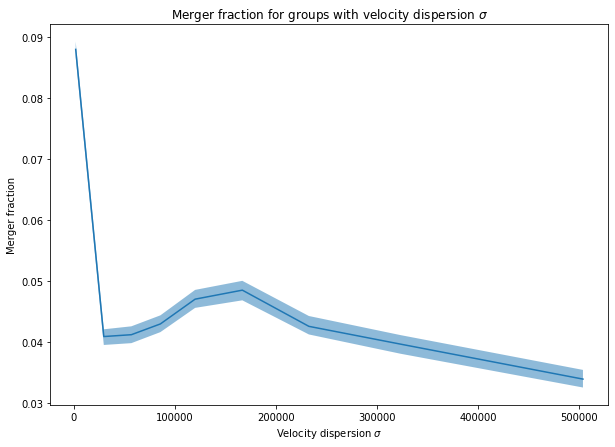

In [70]:
# Define a function that given some data, will return the merger fraction against velocity dispersion
def merger_fraction_velocity_dispersion_binning(data, velocity_bins):
    """Takes data, picks out mergers and calculates the merger fraction using
    the bins provided. Returns an array of merger fraction against galaxy velocity dispersion,
    the average velocity dispersion of galaxies in bin for plotting and the number
    of galaxies and groups in each bin."""
    
    # Resample table with only the data needed
    data = data[["velocity_dispersion", "Merger_classifications", "group id"]]
    
    # Create subset with only one representative per group
    data_pandas = data.to_pandas()
    groups_unique = data_pandas.drop_duplicates(subset=["group id"], keep="first")
    
    # Bin data by velocity dispersion, with the bin sizes specified
    allbinned, bin_edges = np.histogram(data["velocity_dispersion"], bins=velocity_bins)
    groups_unique_binned, bin_edges = np.histogram(groups_unique["velocity_dispersion"], bins=velocity_bins)
    groupsbinned, bin_edges = np.histogram(data["velocity_dispersion"], bins=velocity_bins)
    mergersbinned, bin_edges = np.histogram(data[data["Merger_classifications"] > 0]["velocity_dispersion"], bins=velocity_bins)
    
    # Calculate the average velocity dispersion in each bin for plotting data
    bin_centres=[]
    for i in range(len(bin_edges) - 1):
        bin_centres.append(data[(data["velocity_dispersion"] >= bin_edges[i]) & (data["velocity_dispersion"] < bin_edges[i + 1])]["velocity_dispersion"].mean())
    
    allbinned = allbinned.astype(float)
    mergersbinned = mergersbinned.astype(float)
    
    # Find merger fraction
    merger_fraction_group = mergersbinned / allbinned
    
    return merger_fraction_group, bin_centres, allbinned.astype(int), groups_unique_binned.astype(int)

# Call function with all_data and calculated velocity dispersion bins
merger_fraction_velocity_dispersion, velocity_dispersion_bin_centres, galaxies_in_bin, groups_in_bin = merger_fraction_velocity_dispersion_binning(velocity_data, velocity_dispersion_equal_bins)

# Create dataframe of average group size, merger fraction and gaalxies in each bin and display it
merger_fraction_velocity_dispersion_info = list(zip(velocity_dispersion_bin_centres, merger_fraction_velocity_dispersion, galaxies_in_bin, groups_in_bin))
display(pd.DataFrame(merger_fraction_velocity_dispersion_info, columns=["Average group velocity dispersion in bin", "Merger fraction $f_m$", "Galaxies in bin", "Groups in bin"]))

# Plot a line plot of merger fraction with the minimum and maximum from bootstrapping filled in
plt.figure(figsize=(10,7))
plt.plot(velocity_dispersion_bin_centres, merger_fraction_velocity_dispersion)
plt.fill_between(velocity_dispersion_bin_centres, merger_fraction_velocity_dispersion_bootstrapped_min, merger_fraction_velocity_dispersion_bootstrapped_max, alpha=0.5)
#plt.xscale("log")
plt.xlabel("Velocity dispersion $\sigma$")
plt.ylabel("Merger fraction")
plt.title("Merger fraction for groups with velocity dispersion $\sigma$")
plt.show()

Again we see a very large peak in the first bin at low velocity dispersions. The merger fraction then drops to $\sim 4 \%$, before rising again to another peak of $\sim 5 \%$, and then falls at high velocity dispersions.

It is possible the large peak seen at low velocities and velocity dispersions is due to limitations in our redshift data for these groups. If two galaxies are a close pair undergoing a merger, sometimes SDSS cannot get a spectra for both targets, and therefore no spectroscopic redshift. Instead a redshift is obtained from the nearest-neighbour, which will be the galaxy of the merging pair that has a spectra. The two merging galaxies therefore will have the same redshift, and will give velocities and a velocity dispersion of 0 if there are no other galaxies in the group.

### Group size and velocity dispersion
In the table for the velocity dispersion merger fraction above, the number of galaxies in each velocity dispersion bin is given, along with the number of groups in each bin. Despite the number of galaxies in each bin remaining roughly the same, as the velocity dispersion increases the number of groups in each bin decreases. We can conclude from this that larger groups generally have greater velocity dispersions. To check this we create a scatter plot of velocity dispersion against group size.

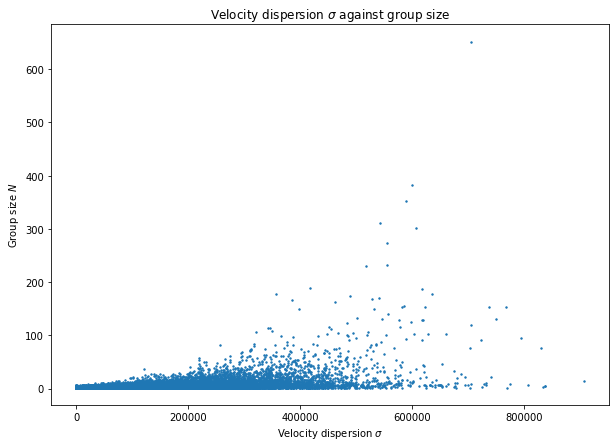

In [82]:
velocity_data_pandas = velocity_data.to_pandas()
groups_unique = velocity_data_pandas.drop_duplicates(subset=["group id"], keep="first")

plt.figure(figsize=(10,7))
plt.scatter(groups_unique["velocity_dispersion"], groups_unique["group_size"], s=2)
plt.xlabel("Velocity dispersion $\sigma$")
plt.ylabel("Group size $N$")
plt.title("Velocity dispersion $\sigma$ against group size")
plt.show()

From the graph we can see that generally, groups with a lower group size tend to have a lower velocity dispersion.

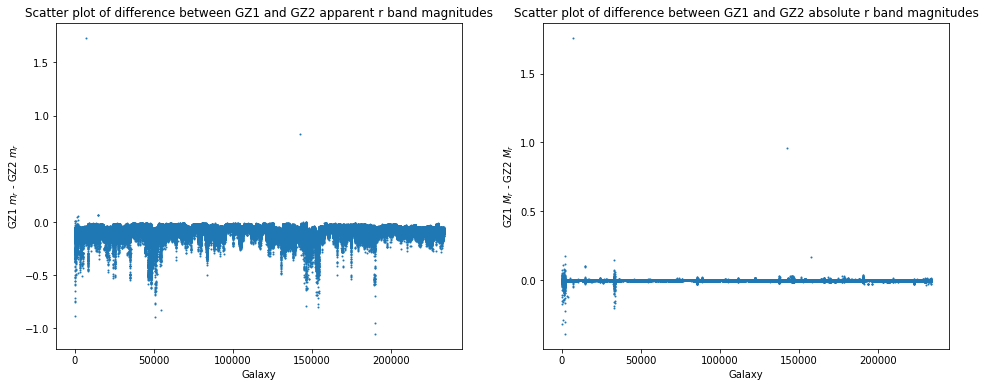

In [90]:
gz1_gz2_spectro_pandas = all_data[(all_data["GZ1_SpectroZ"] == 1) & (all_data["GZ2_SpectroZ"] == 1)][["R_GZ1", "PETROMAG_R_GZ2", "MR_GZ1", "PETROMAG_MR_GZ2"]].to_pandas()

fig, ax = plt.subplots(1, 2, figsize=(16,6))

# Plot a scatter plot of difference between GZ1 and GZ2 apparent r band magnitudes
ax[0].scatter(list(gz1_gz2_spectro_pandas.index), gz1_gz2_spectro_pandas["R_GZ1"] - gz1_gz2_spectro_pandas["PETROMAG_R_GZ2"], s=1)
ax[0].set_xlabel("Galaxy")
ax[0].set_ylabel("GZ1 $m_r$ - GZ2 $m_r$")
ax[0].set_title("Scatter plot of difference between GZ1 and GZ2 apparent r band magnitudes")

# Plot a scatter plot of difference between GZ1 and GZ2 absolute r band magnitudes
ax[1].scatter(list(gz1_gz2_spectro_pandas.index), gz1_gz2_spectro_pandas["MR_GZ1"] - gz1_gz2_spectro_pandas["PETROMAG_MR_GZ2"], s=1)
ax[1].set_xlabel("Galaxy")
ax[1].set_ylabel("GZ1 $M_r$ - GZ2 $M_r$")
ax[1].set_title("Scatter plot of difference between GZ1 and GZ2 absolute r band magnitudes")

fig.subplots_adjust(wspace=0.2)

plt.show()